# Detecting Sarcasam in Reddit Comments

In [1]:
# Importing Required Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from nltk.stem.snowball import EnglishStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV



## EDA

In [3]:
df = pd.read_csv('train-balanced-sarcasm.csv')

In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [6]:
# 53 Missing Values in Comments. 
# This is very miniscule and can be ignored since the size of our dataset is quite large
df.isna().sum()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [7]:
(df['subreddit'].value_counts()[df['subreddit'].value_counts()>5000]/len(df['label']) * 100)

AskReddit          6.497403
politics           3.907208
worldnews          2.609488
leagueoflegends    2.080982
pcmasterrace       1.878463
funny              1.774780
news               1.671097
pics               1.597985
todayilearned      1.400809
nfl                1.399820
nba                1.399523
GlobalOffensive    1.359158
AdviceAnimals      1.333831
videos             1.218869
gaming             1.177910
The_Donald         0.953330
WTF                0.945613
hockey             0.869038
soccer             0.836587
TumblrInAction     0.743589
atheism            0.729837
CFB                0.697288
movies             0.648019
DotA2              0.591626
technology         0.563133
creepyPMs          0.540774
india              0.524252
gifs               0.521086
DestinyTheGame     0.497738
Name: subreddit, dtype: float64

We want to see which subreddit contains the most data points, in this case there isnt one sub-reddit which 
contains a majority. As seen below the highest is 6% from the subreddit 'AskReddit'. in this case there is no 
need to subset our data since the labels are well spread betweeen all the subreddit

In [8]:
# looking at the labels to make sure they are evenly distrubted
print('Label distribution')
df['label'].value_counts()

Label distribution


0    505405
1    505368
Name: label, dtype: int64

In [9]:
# We are inspecting the Data to see what the % is for subreddits that contain label 1 compared to the total number
# of comments.
df.groupby('subreddit')['label'].sum()/df['subreddit'].value_counts()*100

07Scape            0.000000
0x10c            100.000000
0x3642             0.000000
100DaysofKeto      0.000000
100pushups         0.000000
                    ...    
zoophilia        100.000000
zootopia          37.333333
zweiteliga       100.000000
zyramains         60.000000
zyzz              50.000000
Length: 14876, dtype: float64

In [10]:
df['score'].value_counts()

 1       339997
 2       162669
 3        90287
 0        58141
 4        41978
          ...  
 1448         1
 1221         1
 709          1
-87           1
 5629         1
Name: score, Length: 1291, dtype: int64

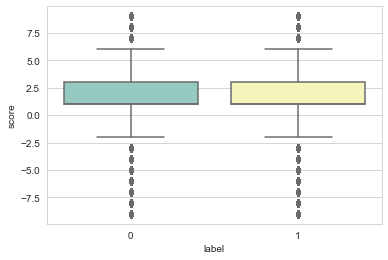

In [11]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="label", y="score",              
data=df[abs(df['score'])<10], palette="Set3")
# Based on the Boxplot we can see that there is no real impact on whether a comment is sarcastic or not
# based on the score therefore using scores would not be a effective way to detect sarcasam in comments.

In [12]:
df['score'].describe()

count    1.010773e+06
mean     6.885999e+00
std      4.834411e+01
min     -5.070000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      9.070000e+03
Name: score, dtype: float64

- Based on the Above analysis we can say that the only real way to detect sarcasam is through the comment alone.
- Will take 100k subset to test out pre-proccessing

### Baseline Model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

cv = CountVectorizer(min_df = 30, stop_words = 'english', strip_accents ='ascii',
                     ngram_range = (2,2)) # analyzer=stemmed_words

In [14]:
X = cv.fit_transform(df['comment'])

In [15]:
X

<1010773x6356 sparse matrix of type '<class 'numpy.int64'>'
	with 510153 stored elements in Compressed Sparse Row format>

In [16]:
# collect the columns which are digits
digitcols = np.array([x.isdigit() for x in cv.get_feature_names()])
print('The number of digit columns is ',np.sum(digitcols))

The number of digit columns is  0


In [17]:
len(cv.get_feature_names())

6356

In [18]:
bag_words = pd.Series(np.asarray(X.sum(axis=0)).reshape(-1),index=cv.get_feature_names())
bag_words

000 000              172
000 people            70
000 year              40
000 years             77
10 000               135
                    ... 
youtube videos        64
yup just              65
yup totally           47
zero tolerance        34
zombie apocalypse     30
Length: 6356, dtype: int64

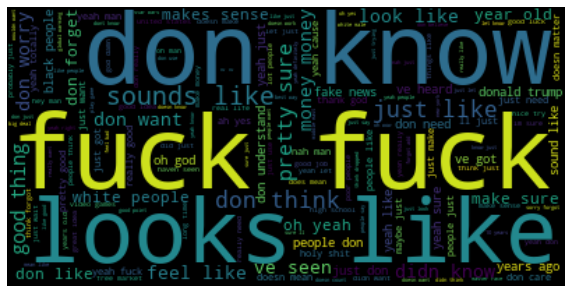

In [19]:
## create word cloud from dataset
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=bag_words)
plt.figure(figsize=(10,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
y = df['label']
y[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64

In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=123)
val_score = cross_val_score(lr, X, y, cv=kf)
y_pred = cross_val_predict(lr, X, y, cv=kf)
val_score.mean()

0.579177521113609

 Accuracy Score: 0.58 
 Recall Score: 0.27 
 F1-Score: 0.39

 TP: 138145 
 TN: 447272 
 FP: 58133 
 FN: 367223


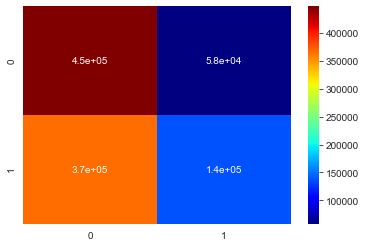

In [100]:
cm = confusion_matrix(y, y_pred)

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

acc_score = accuracy_score(y, y_pred).round(2)
recall = recall_score(y, y_pred).round(2)
f1 = f1_score(y, y_pred, zero_division=1).round(2)


print('','Accuracy Score:',acc_score,'\n','Recall Score:',recall,'\n','F1-Score:', f1)
print()
print('','TP:',tp,'\n','TN:',tn,'\n','FP:',fp,'\n','FN:',fn)
sns.heatmap(cm,annot=True, cmap='jet')

Finding which features(bigrams) contribute most to sarcasm.

In [101]:
lr = LogisticRegression()
lr.fit(X, y)
lrcoef = np.array(lr.coef_)
bigrams_ranked = pd.Series(lrcoef.flatten(), index = cv.get_feature_names()).sort_values()

In [102]:
bigrams_ranked

fair point       -2.530405
just pointing    -2.507105
best luck        -2.491992
just curious     -2.441364
alright thanks   -2.392777
                    ...   
nah bro           3.282631
yes clearly       3.324114
guess added       3.338977
hope forgot       3.749123
think dropped     4.310777
Length: 6356, dtype: float64

In [103]:
best_10_bigrams = bigrams_ranked[-10:]
worst_10_bigrams = bigrams_ranked[:10]
print(best_10_bigrams)
print()
print(worst_10_bigrams)


obviously means    3.158051
sorry dropped      3.159204
tell forgot        3.177485
wow ve             3.209657
human eye          3.217697
nah bro            3.282631
yes clearly        3.324114
guess added        3.338977
hope forgot        3.749123
think dropped      4.310777
dtype: float64

fair point           -2.530405
just pointing        -2.507105
best luck            -2.491992
just curious         -2.441364
alright thanks       -2.392777
just wondering       -2.350705
awesome thanks       -2.236584
remember correctly   -2.227100
far know             -2.168858
thoughts exactly     -2.161115
dtype: float64


Testing on new data

In [104]:
X = df['comment']
y = df['label']

In [105]:
# lr.fit(X, y)

# new_Sentence = 'really dude'
# x = cv.transform([new_Sentence])
# lr.predict_proba(x)
X = df['comment'].sample(25000)
y = y[X.index]

In [106]:
X.shape, y.shape

((25000,), (25000,))

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

def model_build(model, X, y, params_tfi, params_model={}, n_splits=5, grid_search=False, param_grid = {}):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    tfi = TfidfVectorizer(**params_tfi)
    ml = model(**params_model)

    steps = [('tfi',tfi),('ml', ml)]
    pipe = Pipeline(steps)
    
    
    if grid_search == False:
        pipe.fit(X, y) # only using fit as we include ML within the pipeline, if we need score or predict we need to
                          # individually call that method/function


        
        val_score = cross_val_score(pipe, X, y, cv=kf)
        
        print(f'CV score = {val_score.mean():.3f}')
    else:
        search = GridSearchCV(pipe, param_grid, n_jobs=-1)
        search.fit(X, y)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        pipe = search.best_estimator_
    
    y_pred = cross_val_predict(pipe, X, y, cv=kf)
    
    return pipe, y_pred

In [109]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
params_tfi = {'min_df': 0.05, 'max_df': 0.99,'max_features':5000, 'stop_words':'english', 'strip_accents': 'ascii',
                     'ngram_range':(1,2)}
param_grid = {
    'ml__C': np.logspace(-4, 4, 4),
    'tfi__min_df': np.linspace(0,0.05,6),
    'tfi__max_df': np.linspace(0.95,1.0,6)
}
lr = LogisticRegression
pipe_lr, y_pred_lr = model_build(lr,X,y,params_tfi, grid_search = True, param_grid = param_grid)


Best parameter (CV score=0.634):
{'ml__C': 0.046415888336127774, 'tfi__max_df': 0.95, 'tfi__min_df': 0.0}


In [110]:
def model_results(y,y_pred):
    cm = confusion_matrix(y, y_pred)

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    acc_score = accuracy_score(y, y_pred).round(2)
    recall = recall_score(y, y_pred).round(2)
    f1 = f1_score(y, y_pred, zero_division=1).round(2)


    print('','Accuracy Score:',acc_score,'\n','Recall Score:',recall,'\n','F1-Score:', f1)
    print()
    print('','TP:',tp,'\n','TN:',tn,'\n','FP:',fp,'\n','FN:',fn)
    display(sns.heatmap(cm,annot=True, cmap='jet'))

 Accuracy Score: 0.63 
 Recall Score: 0.52 
 F1-Score: 0.59

 TP: 6484 
 TN: 9350 
 FP: 3106 
 FN: 6060


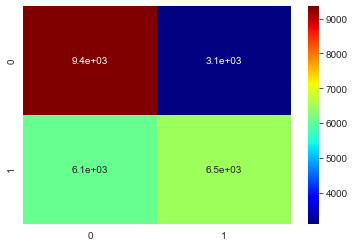

In [111]:
model_results(y, y_pred_lr)

In [112]:
# random forest grid search
# maybe try first we reduced maybe 50%, 25%, 10%

In [124]:
from sklearn.ensemble import RandomForestClassifier
params_tfi = {'min_df': 0.05, 'max_df': 0.99,'max_features':5000, 'stop_words':'english', 'strip_accents': 'ascii',
                     'ngram_range':(1,2)}

param_grid = {'ml__max_depth': range(10,101,50),
              'ml__n_estimators': range(100,501,100),
              'tfi__min_df': np.linspace(0,0.05,6),
              'tfi__max_df': np.linspace(0.95,1.0,6),
              'tfi__max_features':range(10000,50001,10000)}
              
rf = RandomForestClassifier# dont add () , ask again why since i cant remember what reason was

pipe_rf, y_pred_rf = model_build(rf, X, y, params_tfi, grid_search= True, param_grid= param_grid)

Best parameter (CV score=0.620):
{'ml__max_depth': 9, 'ml__n_estimators': 100, 'tfi__max_df': 0.98, 'tfi__min_df': 0.0}


 Accuracy Score: 0.62 
 Recall Score: 0.43 
 F1-Score: 0.53

 TP: 5413 
 TN: 10075 
 FP: 2381 
 FN: 7131


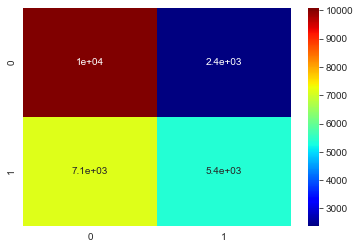

In [125]:
model_results(y,y_pred_rf)

CV score = 0.721
 Accuracy Score: 0.72 
 Recall Score: 0.68 
 F1-Score: 0.71

 TP: 345603 
 TN: 382782 
 FP: 122623 
 FN: 159765


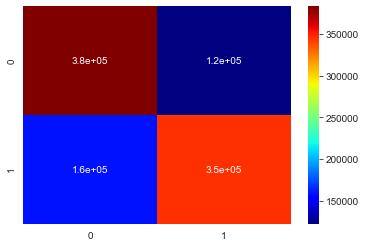

In [128]:
X,y = df['comment'], df['label']
params_tfi = {'min_df': 2,'max_features':50000, 'ngram_range':(1,2)}

params_model = {'random_state': 17}
              
pipe_lr, y_pred_lr = model_build(LogisticRegression, X, y, params_model = params_model, params_tfi = params_tfi)
model_results(y,y_pred_lr)

In [129]:
# try min_df up to 100 and see if accuracy remains 0.72


# Neural Network approach

In [164]:
# Neural Network
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split


In [165]:
params_tfi = {'min_df': 2,'max_features':5000, 'ngram_range':(1,2)}
tfi = TfidfVectorizer(**params_tfi)
sample_df = df.sample(50000)
X = tfi.fit_transform(sample_df['comment'])
y = sample_df['label']

X_train,X_test, y_train,y_test  = train_test_split(X,y, test_size = 0.15, random_state = 123)

In [168]:
model = Sequential([
    Dense(64,  activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [169]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________


In [170]:
history = model.fit(X_train, y_train, epochs=10, batch_size = 1000, validation_split = 0.15)

Train on 36125 samples, validate on 6375 samples
Epoch 1/10
36125/36125 [==============================] - 4s 105us/sample - loss: 0.6867 - accuracy: 0.5802 - val_loss: 0.6764 - val_accuracy: 0.6362
Epoch 2/10
36125/36125 [==============================] - 3s 90us/sample - loss: 0.6561 - accuracy: 0.6674 - val_loss: 0.6467 - val_accuracy: 0.6530
Epoch 3/10
36125/36125 [==============================] - 3s 88us/sample - loss: 0.6198 - accuracy: 0.6897 - val_loss: 0.6247 - val_accuracy: 0.6569
Epoch 4/10
36125/36125 [==============================] - 3s 92us/sample - loss: 0.5914 - accuracy: 0.7013 - val_loss: 0.6129 - val_accuracy: 0.6621
Epoch 5/10
36125/36125 [==============================] - 3s 92us/sample - loss: 0.5715 - accuracy: 0.7140 - val_loss: 0.6072 - val_accuracy: 0.6629
Epoch 6/10
36125/36125 [==============================] - 3s 81us/sample - loss: 0.5580 - accuracy: 0.7203 - val_loss: 0.6060 - val_accuracy: 0.6629
Epoch 7/10
36125/36125 [==============================] 

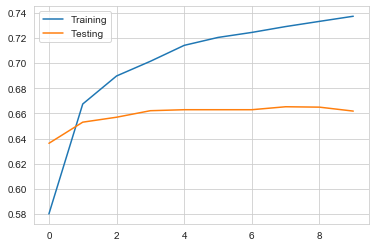

In [171]:
plt.plot(history.history['accuracy'], label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Testing')
plt.legend()

In [ ]:
# Gradient Boosting

# investigate the keras better ways of generalizing